<a href="https://colab.research.google.com/github/ReboreExplore/GAN-Papers-Implementation/blob/main/GAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I have implemented the paper "**Generative Adversarial Networks**" by Goodfellow et. al. I have used the MNIST dataset which is a handwritten digits dataset with 10 classes.

Framework used : *Pytorch*

## Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.nn import BatchNorm2d, Dropout
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from tqdm.auto import tqdm

## Dataset preprocessing

In [ ]:
dim = 28 # Data image dimension (28*28*1)
batch_size = 128
latent_dims = 64 # Generator noise input dimensions

### Download dataset and apply transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))
    ]) # (0.5,) is used as MNIST dataset consists of only grayscale images

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transform, 
    download = True,            
)

### Visualize the dataset

In [ ]:
# Check the dimensions and visualize the images
print(f'The shape and type of the images in the dataset is {train_data.data[0].shape}')
print(f'The total number of images in the dataset: {len(train_data)}')
print(f'Visualizing the first image.....\n')
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

### Create the Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

## Models

### Discriminator Model

In [ ]:
# Create the discriminator class
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(dim*dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.layers(x)
    return x

In [ ]:
dis_model = Discriminator()
dis_model

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
# discriminator unit test
test_image = torch.randn(1, 1, 28, 28)
dis_model(test_image)

tensor([[0.5095]], grad_fn=<SigmoidBackward>)

### Generator Model

In [ ]:
# Create the generator class
class Generator(nn.Module):
  def __init__(self, latent_dims):
    super(Generator, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(latent_dims,128),
        nn.BatchNorm1d(num_features = 128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.Dropout(0.3),
        nn.ReLU(),
        nn.Linear(512,dim*dim),
        nn.Tanh(),
    )

    
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), 1, dim, dim)
    return x

In [ ]:
gen_model = Generator(latent_dims)

In [ ]:
# generator test
test_latent = torch.randn(batch_size,64)
out = gen_model(test_latent)
out.shape

torch.Size([128, 1, 28, 28])

In [ ]:
gen_model

Generator(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=784, bias=True)
    (10): Tanh()
  )
)

## Training 

### Initializations

In [ ]:
disc_m = Discriminator()
gen_m = Generator(latent_dims)

In [ ]:
train_steps = 5000
disc_steps = 1 
gen_steps = 3

### Helper Functions

In [ ]:
# helper function to get the noise signals
def get_noise_samples(batch_size, dims):
    return torch.randn([batch_size, dims])

In [ ]:
# Applying label smoothing
def get_real_labels(batch_size):
  real_labels = torch.randint(8,10,(batch_size,1))
  return torch.mul(real_labels,0.1)

def get_fake_labels(batch_size):
  fake_labels = torch.randint(0,2,(batch_size,1))
  return torch.mul(fake_labels,0.1)

### Train Loop

In [ ]:
def train_loop(disc, gen, epochs, disc_epochs, loader, batch_size, latent_dims):
    
    disc_optimizer = optim.Adam(disc.parameters(), lr = 0.0005)
    gen_optimizer = optim.Adam(gen.parameters(), lr = 0.0005) 
    criterion = nn.BCELoss()
    
    pbar = tqdm(range(train_steps))
    total_disc_loss = []
    total_gen_loss = []

    for i in pbar:
      disc_loss_per_k = []
      gen_loss_per_k = []
      
      # discriminator training
      for j in range(disc_steps):
        real_data, _ = next(iter(loader))
        noise_vector = get_noise_samples(batch_size, latent_dims)
        
        real_label_pred = disc(real_data)
        fake_data = gen(noise_vector)
        fake_label_pred = disc(fake_data.detach())
        
        real_label = get_real_labels(batch_size)
        fake_label = get_fake_labels(batch_size)
        # disc_loss = - torch.mean((torch.log(real_image)) +(torch.log(1 - fake_image)))
        
        real_loss = criterion(real_label_pred,real_label)
        fake_loss = criterion(fake_label_pred,fake_label)

        disc_loss = real_loss + fake_loss
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        disc_loss_per_k.append(disc_loss.item())
      
     # generator training
      for k in range(gen_steps):
        noise_vector = get_noise_samples(batch_size, latent_dims)
        gen_image = gen(noise_vector)
        fake_but_real_pred = disc(gen_image)

        fake_but_real_label = get_real_labels(batch_size)

        # gen_loss = - torch.mean(torch.log(fake_but_real_pred))
        gen_loss = criterion(fake_but_real_pred, fake_but_real_label)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_per_k.append(gen_loss.item())
      
      total_disc_loss.append(np.mean(disc_loss_per_k))
      total_gen_loss.append(np.mean(gen_loss_per_k))
      # print(len(total_disc_loss))
      # print(len(total_gen_loss))

      pbar.set_description(f"D_loss: {np.mean(total_disc_loss):.4f}, G_loss: {np.mean(total_gen_loss):.4f}")
    
    return total_disc_loss,total_gen_loss

In [ ]:
disc_loss, gen_loss = train_loop(disc_m, gen_m, train_steps, disc_steps, train_loader, batch_size, latent_dims)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Visualize the output

torch.Size([25, 1, 28, 28])


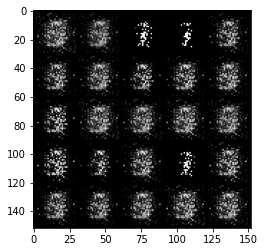

In [ ]:
# check output
test_noise_vectors = get_noise_samples(25, 64)
gen_images = gen_m(test_noise_vectors)
print(gen_images.shape)
grid = torchvision.utils.make_grid(gen_images, nrow=5, normalize=True)

np_grid = grid.numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))
plt.imshow(np_grid)

In [ ]:
sample_size = 5
disc_loss = disc_loss[0::sample_size]
gen_loss = gen_loss[0::sample_size]

In [ ]:
# # Check
# print(len(gen_loss))
# print(type(gen_loss))
# epochs = [i for i in np.arange(0,train_steps,sample_size)]
# len(epochs)

### Plot Discriminator and Generator Loss

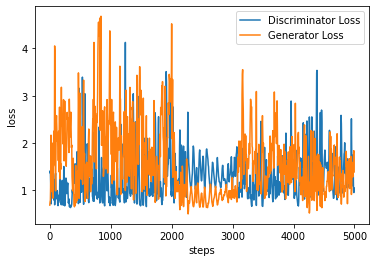

In [ ]:
# plotting function
epochs = [i for i in np.arange(0,train_steps,sample_size)]
plt.plot(epochs, disc_loss, label = "Discriminator Loss")
plt.plot(epochs, gen_loss, label = "Generator Loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()
plt.show()